# Continuous-Time Schelling with Unhappiness-Driven

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

rng = np.random.RandomState(42)

## Utilities: Grid graph and neighborhoods
- 4-neighborhood 
- Mahattan distance for movement cost

In [46]:
def grid_neighbors(shape: Tuple[int, int], pos: Tuple[int, int]) -> List[Tuple[int, int]]:
    """Get 4-connected neighbors on a grid"""
    H, w = shape
    r, c = pos
    nbrs = []
    if r > 0: 
        nbrs.append((r-1, c))
    if r < H - 1:
        nbrs.append((r+1, c))
    if c > 0:
        nbrs.append((r, c-1))
    if c < w - 1:
        nbrs.append((r, c+1))
    return nbrs

In [47]:
def manhattan(a: Tuple[int, int], b: Tuple[int, int]) -> int:
    return abs(a[0] - b[0]) + abs(a[1] - b[1])


## State helpers
- f is an (H, W) integer array: 0=empty, 1..q-1 = type/color
- occupied positions and vacancies

In [48]:
def occupied_positions(f: np.ndarray) -> List[Tuple[int, int]]:
    return list(map(tuple, np.argwhere(f>0)))

def vacancy_positions(f: np.ndarray) -> List[Tuple[int, int]]:
    return list(map(tuple, np.argwhere(f==0)))

def total_happiness(f: np.ndarray) -> float:
    """ H(f) = -sum_v c(f, v). Only occupied contribute"""
    H, W = f.shape
    total = 0.0
    for r, c in occupied_positions(f):
        total -= local_unhappiness(f, (r, c))
    return total
    

## Unhappiness and destination evaluation
- c(f, v): fraction of unlike among occupied neighbors (0 if v empty)
- p_i(x; f): same-type share if agent at v moved to empty x (hypothetical)
- Score S_i(x, f): u(p) - \lambda_dist * dist

In [49]:
def local_unhappiness(f: np.ndarray, v: Tuple[int, int]) -> float:
    """ c(f, v)= (#unlike neighbors) / (#occupied neighbors) for the agent v
    If v is empty or no occupied neighbors, return 0 by convention
    """
    t = f[v]
    nbrs = grid_neighbors(f.shape, v)
    occ = [u for u in nbrs if f[u] != 0]
    if not occ:
        return 0.0
    unlike = sum(1 for u in occ if f[u] != t)
    return unlike/len(occ)

def same_type_share_if_moved(f: np.ndarray, v_from: Tuple[int, int], x_to: Tuple[int, int]) -> float:
    """ 
    p_i(x;f): fraction of same-type neighbors at x if agent at v_from moves there.
    if all neighbors of x are empty, returns 1 (fully 'satisfied alone').
    """
    t = f[v_from]
    assert t != 0, "source must be occupied"
    # neighbors of destination, but source becomes empty and destination becomes t
    nbrs = grid_neighbors(f.shape, x_to)
    occ = [u for u in nbrs if not (u==v_from) and f[u]!=0]
    # v_from vacates, so ignore it even if neighbor
    if not occ:
        return 1.0
    same = sum(1 for u in occ if f[u]==t)
    return same/len(occ)

def score_destination(f: np.ndarray, v_from: Tuple[int, int], x_to: Tuple[int, int],
                        lam_dist: float=0.0, u_fn=lambda p: p) -> float:
    """
    S_i(x;f) = u(p_i(x;f))-lam_dist*dist(v_from, x_to)
    """    
    p = same_type_share_if_moved(f, v_from, x_to)
    return u_fn(p) - lam_dist * manhattan(v_from, x_to)
    

## Softmax choice and rate function
- softmax over candidate destinations with temperature $\mu$
- $\lambda_i=g(c_i)$ with $g(x)=x^{\mu}$ ($\mu\geq1$ makes urgency convex)

In [50]:
def softmax_probs(scores: np.ndarray, temperature: float) -> np.ndarray:
    if len(scores) == 0:
        return np.array([])
    tau = max(1e-12, float(temperature))
    z = (scores/tau)
    z -= z.max() # numerical stability
    p = np.exp(z)
    p /= p.sum()
    return p

def rate_from_unhappiness(c: float, gamma: float=1.0, lam_max: float=1.0, lam_floor: float=0.0) -> float:
    """
    lambda = lam_floor + lam_max * c ** gamma (monotone in c)
    """
    return lam_floor + lam_max * (c ** gamma)


## One Gillespie event:
1. Compute all $\lambda_i$ from current $c_i$
2. Sample next time $\Delta t \sim \exp(\sum \lambda_i)$; choose agent $i$ with prob $\lambda_i/\sum _\lambda$
3. Agent i samples destination x via softmax over $S_i(x;f)$
4. Metropolis accept (or accept_all = true), then update f and time.


In [51]:
@dataclass
class SimParams:
    q: int = 3 # number of colors including 0 (empty) => types = {1..q-1}
    mu: float = 0.3 # softmax temperature
    lam_dist: float = 0.05 # distance penalty
    gamma: float = 1.0 # rate exponent (\lambda \propto c^gamma)
    lam_max: float = 1.0 # max rate scale
    lam_floor: float = 0.0 # min rate (0->fully happy agents)
    accept_all: bool = True # if False, use Metropolis accept
    u_fn: callable = lambda p:p # utility function in score

In [52]:
def choose_agent_by_rates(rates: np.ndarray, rng: np.random.Generator) -> Optional[int]:
    total = rates.sum()
    if total <= 0:
        return None
    r = rng.random() * total
    s = 0.0
    for i, lam in enumerate(rates):
        s += lam
        if r <= s:
            return i
    return len(rates) - 1

def metropolis_accept(H_old: float, H_new: float, rng: np.random.Generator) -> bool:
    if H_new >= H_old:
        return True
    ratio = H_new/max(1e-12, H_old)
    return rng.random() < ratio





## Simulation driver (continuous time)
Returns a history dict (times, H, mean local happiness, snapshots)


In [53]:
def mean_local_happiness(f: np.ndarray) -> float:
    """Average (1 - c(f,v)) over occupied sites."""
    occ = occupied_positions(f)
    if not occ: 
        return 1.0
    vals = [1.0 - local_unhappiness(f, v) for v in occ]
    return float(np.mean(vals))

In [54]:
def simulate_ctmc(
    f0: np.ndarray,
    params: SimParams,
    max_events: int = 10_000,
    max_time: float = np.inf,
    snapshot_every: int = 200
) -> Dict[str, object]:
    f = f0.copy()
    H_series = []
    mean_happy_series = []
    t_series = []
    snaps = []
    times = []

    t = 0.0 
    H_cur = total_happiness(f)
    H_series.append(H_cur)
    t_series.append(t)
    mean_happy_series.append(mean_local_happiness(f))
    snaps.append(f.copy())
    times.append(t)

    H, W = f.shape
    for ev in range(max_events):
        occ = occupied_positions(f)
        if not occ:
            break

        # compute per - agent rates lambda_i
        cs = np.array([local_unhappiness(f, v) for v in occ], dtype= float)
        rates = np.array([rate_from_unhappiness(c, params.gamma, params.lam_max, params.lam_floor) for c in cs], dtype=float)
        
        lam_tot = rates.sum()
        
        # no one wants to move => absorbing (or nearly state)
        if lam_tot <= 0:
            break

        # sample next event time
        dt = rng.exponential(1.0/lam_tot)
        if t + dt > max_time:
            break
        t += dt

        # choose agent by rates
        idx = choose_agent_by_rates(rates, rng)
        v_from = occ[idx]

        # build destination candidates
        vacs = vacancy_positions(f)
        if not vacs:
            # no place to move: skip (self-loop)
            t_series.append(t)
            H_series.append(H_cur)
            mean_happy_series.append(mean_local_happiness(f))
            continue

        # score destinations and sample with softmax
        scores = np.array([score_destination(f, v_from, x, params.lam_dist, params.u_fn) for x in vacs], dtype = float)
        probs = softmax_probs(scores, params.mu)
        if probs.size == 0 or np.isnan(probs).any():
            # numerical guard
            x_to = vacs[rng.random_integers(0, len(vacs))]
        else:
            choice = rng.choice(len(vacs), p=probs)
            x_to = vacs[choice]

        # propose update and compute H_new
        f_new = f.copy()
        t_from = f[v_from]
        f_new[v_from] = 0
        f_new[x_to] = t_from

        H_new = total_happiness(f_new)

        # accept?
        accepted = True if params.accept_all else metropolis_accept(H_cur, H_new, rng)
        if accepted:
            f = f_new
            H_cur = H_new
        
        # record
        t_series.append(t)
        H_series.append(H_cur)
        mean_happy_series.append(mean_local_happiness(f))
        if (ev+1) % snapshot_every == 0:
            snaps.append(f.copy())
            times.append(t)
    return dict(
        t=np.array(t_series),
        H=np.array(H_series),
        mean_happy = np.array(mean_happy_series),
        snapshots = snaps,
        snapshot_times = np.array(times),
        final_state = f,
    )

## Initialization helpers
- random initialization with vacancy rate p_0 and types {1..q-1}
- optionally bias intial mix (probabilities per type)

In [55]:
def random_init(H: int, W: int, q: int=3, vacancy_rate: float = 0.1, type_probs: Optional[np.ndarray]=None) -> np.ndarray:
    """
    Create random state with given vacancy rate and type distribution
    """
    assert 0 <= vacancy_rate < 1
    f = np.zeros((H, W), dtype = int)
    n= H*W
    k_vac = int(round(vacancy_rate* n))
    all_cells = [(r,c) for r in range(H) for c in range(W)]
    rng.shuffle(all_cells)
    vac_cells = set(all_cells[:k_vac])
    occ_cells = all_cells[k_vac:]
    # types 1..q-1
    T = q-1
    if type_probs is None:
        type_probs = np.ones(T)/T
    for cell in occ_cells:
        f[cell] = 1 + rng.choice(T, p=type_probs)
    return f

In [56]:
def plot_grid(f: np.ndarray, title: str=" ", cmap = "tab20", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(f, cmap=cmap, vmin=0, vmax=f.max() if f.max()>0 else 1)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

## Demo Run
- small grid for speed; increase size for richer patterns
- try toggling `accept_all` (true/false) and `gamma` (1-> linear, 2+ -> strongly prioritize very unhappy)

In [65]:
H, W = 30,30
q = 3
vacancy = 0.15
f0 = random_init(H, W, q=q, vacancy_rate=vacancy)

params = SimParams(
    q=q,
    mu=0.2, # lower -> greedier destination choice
    lam_dist = 0.05, # movement cost for distance
    gamma = 2.0, # rate exponent \lambda \propto c^gamma
    lam_max = 1.0,
    lam_floor=0.0,
    accept_all=False, # set False to use Metropolis acceptance
    u_fn= lambda p: p # utility = same-type share
)

res = simulate_ctmc(f0, params, max_events=10000, snapshot_every=300)

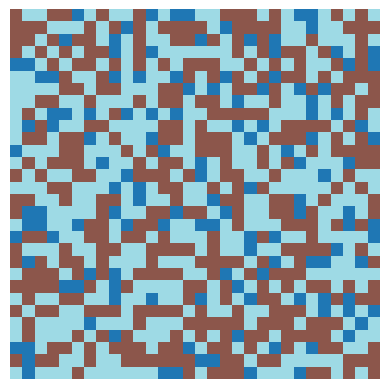

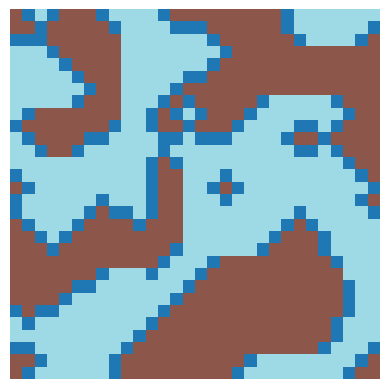

In [73]:
# visualize intial and final
# fig, axes = plt.subplots(1, 2, figsize=(10,5))
# plot_grid(f0, ax=axes[0])
# plot_grid(res["final_state"], ax=axes[1])
# plt.savefig("figures/simulation.png", bbox_inches="tight", dpi=1200)

for grid, name in zip([f0, res["final_state"]], ["initial", "final"]):
	fig, ax = plt.subplots()
	Z = grid/abs(grid).max()
	ax.imshow(Z, cmap="tab20", vmin=0, vmax=1)
	ax.set_axis_off()
	ax.set_aspect("equal")

	plt.savefig(f"figures/{name}.png", bbox_inches="tight", dpi=1200)


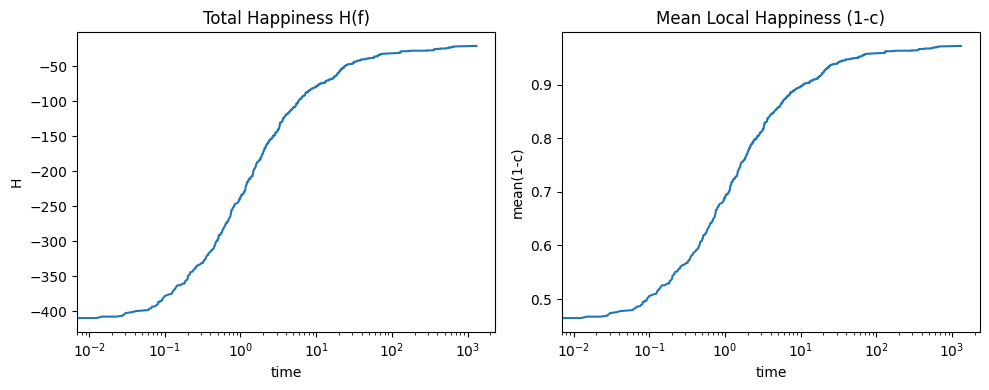

In [67]:
# metrics over time
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(res["t"], res["H"])
ax[0].set_title("Total Happiness H(f)")
ax[0].set_xlabel("time")
ax[0].set_xscale("log")
ax[0].set_ylabel("H")

ax[1].plot(res["t"], res["mean_happy"])
ax[1].set_title("Mean Local Happiness (1-c)")
ax[1].set_xlabel("time")
ax[1].set_xscale("log")
ax[1].set_ylabel("mean(1-c)")
plt.tight_layout()
plt.show()

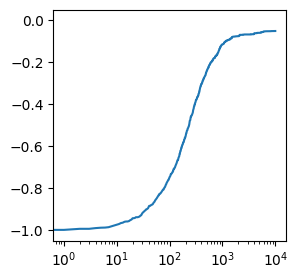

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))

# normalize data
X = np.arange(len(res["t"]))
# X = res["t"]
Y = res["H"]/abs(res["H"]).max()

ax.plot(X, Y)

ax.set_xscale("log")
ax.set_ylim(-1.05, 0.05)

plt.savefig("figures/total-happiness.png", bbox_inches="tight", dpi=1200)

## Snapshots through time
Inspect the spatial evolution. Increase `snapshot_every` for more frames.

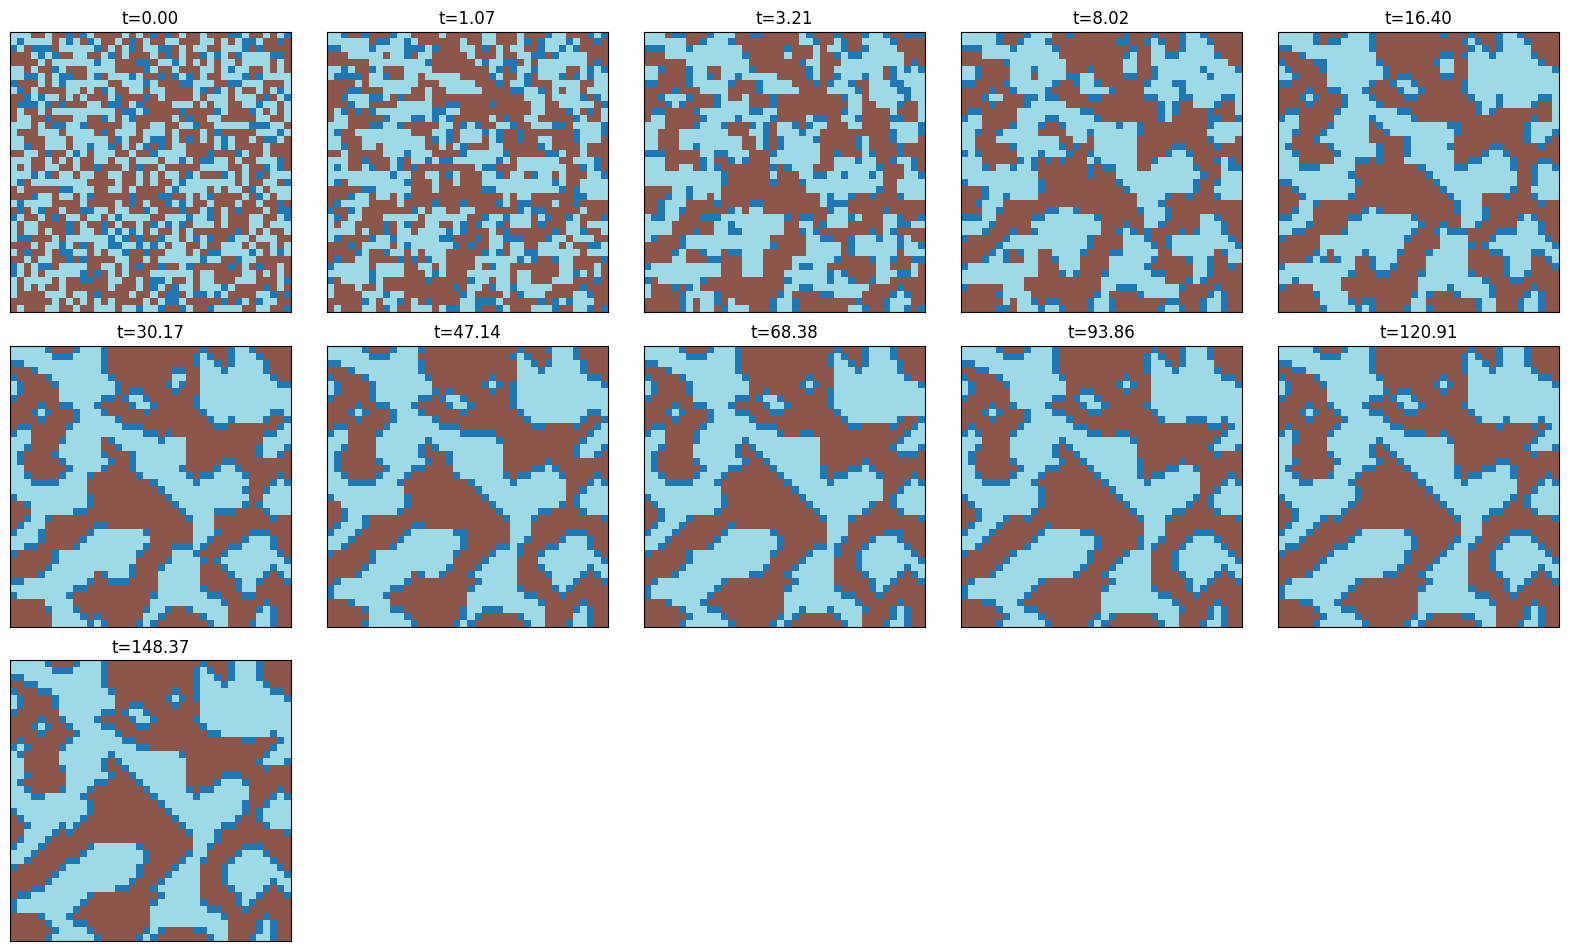

In [28]:
# %%
snaps = res["snapshots"]
times = res["snapshot_times"]
cols = min(5, len(snaps))
rows = int(np.ceil(len(snaps)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows))
axes = np.array(axes).reshape(rows, cols)

for i, f in enumerate(snaps):
    r, c = divmod(i, cols)
    plot_grid(f, f"t={times[i]:.2f}", ax=axes[r, c])

# hide empty axes
for j in range(len(snaps), rows*cols):
    r, c = divmod(j, cols)
    axes[r, c].axis('off')

plt.tight_layout(); plt.show()


## Approximate stationary behavior
We approximate the stationary distribution over a macro-variable by sampling the trajectory after a burn-in window. Here we use H(f) bins.

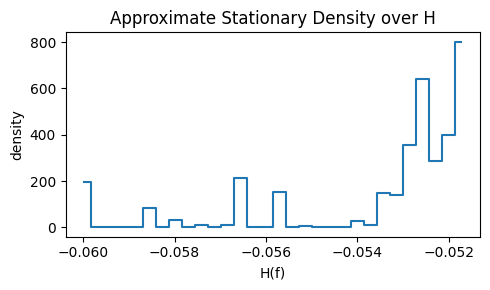

In [74]:
# %%
def stationary_histogram(values: np.ndarray, burnin_frac: float = 0.5, bins: int = 30):
    n = len(values)
    start = int(np.floor(burnin_frac * n))
    data = values[start:]
    hist, edges = np.histogram(data, bins=bins, density=True)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, hist

centers, dens = stationary_histogram(Y, burnin_frac=0.5, bins=30)
plt.figure(figsize=(5,3))
plt.plot(centers, dens, drawstyle="steps-mid")
plt.title("Approximate Stationary Density over H")
plt.xlabel("H(f)"); plt.ylabel("density")
plt.tight_layout(); plt.show()


## Sensitivity experiments
Explore how parameters affect behavior:
 - gamma ↑ : heavily prioritize very unhappy agents
 - mu ↓    : greedier destination choice (less exploration)
 - lam_dist↑: penalize long moves (promote local compaction)
 - accept_all=False : introduce MH acceptance wrt H(f)

In [75]:
# %%
def run_experiment(gamma_list=[1.0, 2.0, 3.0], mu_list=[0.2, 0.5, 1.0], reps=3):
    H_last = np.zeros((len(gamma_list), len(mu_list)))
    for i, gexp in enumerate(gamma_list):
        for j, mu in enumerate(mu_list):
            vals = []
            for _ in range(reps):
                f0 = random_init(H, W, q=q, vacancy_rate=vacancy)
                params = SimParams(mu=mu, gamma=gexp, lam_dist=0.05, accept_all=False, q=q)
                res = simulate_ctmc(f0, params, max_events=3000)
                vals.append(res["H"][-1])
            H_last[i, j] = np.mean(vals)
    return H_last

gamma_list = [1.0, 2.0, 3.0]
mu_list = [0.15, 0.3, 0.6]
Hgrid = run_experiment(gamma_list, mu_list, reps=3)

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(Hgrid, cmap="viridis")
ax.set_xticks(range(len(mu_list))); ax.set_xticklabels([f"μ={m}" for m in mu_list])
ax.set_yticks(range(len(gamma_list))); ax.set_yticklabels([f"γ={g}" for g in gamma_list])
ax.set_title("Avg final H by (γ, μ)")
plt.colorbar(im, ax=ax, label="avg final H")
plt.tight_layout(); plt.show()


KeyboardInterrupt: 